El objetivo de este notebook es cargar los archivos csv de la tasa objetivo, INPC y tipo de cambio para limpiarlos, transformar las fechas a data_time y poner las fechas como indices. Ademas, limpiar los datos y ajustar los datos diarios para homologarlos a mensuales. 

In [17]:
import pandas as pd 
import os
import sys
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


#Nos permite subir de nivel para acceder a otras carpetas
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from banxico_utils import convertirDF
#Guardar la direccion de la carpeta donde estan nuestros archivos     
data_dir = os.path.join(project_root, 'data')
print(f"Buscando datos en: {data_dir}")

#Construimos las rutas finales a los CSV
ruta_tasa = os.path.join(data_dir, "TasaObjetivo.csv")
ruta_INPC = os.path.join(data_dir, "INPCGeneral.csv")
ruta_tipo_cambio = os.path.join(data_dir, "TipoDeCambio.csv")




#Cargar archivos csv
try:
    df_TasaObjetivo=pd.read_csv(ruta_tasa)
    df_INPC=pd.read_csv(ruta_INPC)
    df_TipoCambio=pd.read_csv(ruta_tipo_cambio)
    print("Archivos cargados con exito; DF creados.")
except FileNotFoundError:
    print("Error al cargar archivos")
    
    
#Llamar a funcion para convertir fechas 
df_TasaObjetivoI=convertirDF(df_TasaObjetivo)
df_INPCI=convertirDF(df_INPC)
df_TipoCambioI=convertirDF(df_TipoCambio)

#Imprimir DF solo para comprobar que se hayan aplicado los cambios a los DF
print(df_TasaObjetivoI.head(5))
print(df_INPCI.head(5))
print(df_TipoCambioI.head(5))
    
    

Buscando datos en: d:\PROYECTOS AMBICIOSOS\Banxico-policy-analysis\data
Archivos cargados con exito; DF creados.
            dato
fecha           
2008-01-21   7.5
2008-01-22   7.5
2008-01-23   7.5
2008-01-24   7.5
2008-01-25   7.5
                 dato
fecha                
2008-01-01  65.350564
2008-02-01  65.544834
2008-03-01  66.019891
2008-04-01  66.170127
2008-05-01  66.098635
               dato
fecha              
2008-01-02  10.8972
2008-01-03  10.8842
2008-01-04  10.9277
2008-01-07  10.9208
2008-01-08  10.8850


El siguiente paso es conseguir que todos los datos queden en una serie de tiempo mensual. Como cada dato tiene una naturaleza diferente, se tratarán de distintas formas.
Tambien haremos una concatenacion para guardar los tres df en un unico df


In [18]:
#Usar resample para INPC que ya es mensual, pero queremos que se asigne al ultimo dia de dicho mes
df_INPCm=df_INPCI.resample("ME").mean()
#Usar resample para tipo de cambio
df_TipoCambiom=df_TipoCambioI.resample("ME").mean()
#Usar resample para tasa objetivo
df_TasaObjetivom=df_TasaObjetivoI.resample("ME").asfreq().ffill()

#Crear nuestro dataframe maestro concatenando los tres df
listaDF=[df_INPCm,df_TipoCambiom,df_TasaObjetivom]

df_maestro=pd.concat(listaDF,axis=1,join="outer",ignore_index=False).dropna()
print(df_maestro.head(5))



"""""
#Crear ruta para guardar el dataframe maestro 
ruta_dfMaestro=os.path.join(data_dir, "DataFrameMaestro.csv")

#Guardar en archivo csv
df_maestro.to_csv(ruta_dfMaestro,index=False)
"""


                 dato       dato  dato
fecha                                 
2008-01-31  65.350564  10.910014   7.5
2008-02-29  65.544834  10.766530   7.5
2008-03-31  66.019891  10.731311   7.5
2008-04-30  66.170127  10.515350   7.5
2008-05-31  66.098635  10.435152   7.5


'""\n#Crear ruta para guardar el dataframe maestro \nruta_dfMaestro=os.path.join(data_dir, "DataFrameMaestro.csv")\n\n#Guardar en archivo csv\ndf_maestro.to_csv(ruta_dfMaestro,index=False)\n'

Normalizar los datos utilizando el objeto de la libreria scikit-learn para que estén en la misma escala. Posterior a eso graficarlos.

                dato      dato      dato
fecha                                   
2008-01-31  0.000000  0.056547  0.545455
2008-02-29  0.002561  0.046412  0.545455
2008-03-31  0.008825  0.043924  0.545455
2008-04-30  0.010806  0.028668  0.545455
2008-05-31  0.009863  0.023003  0.545455


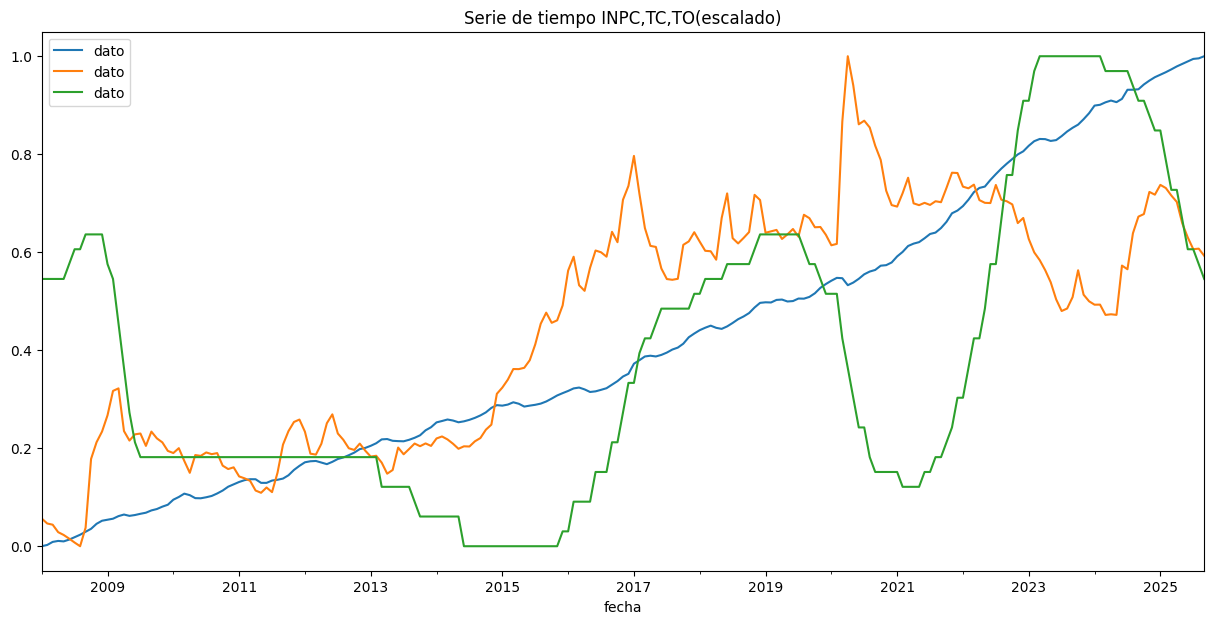

In [19]:
#Crear instancia del objeto 
escalador=MinMaxScaler()

#Usar metodo para calcular los maximo y minimo del conjunto de datos
maestroEscalado=escalador.fit_transform(df_maestro)

#Primero estan los valores del INPC, despues los valores del tipo de cambio y por ultimo la tasa objetivo
#print(maestroEscalado)

#Transformar array de numpy en dataframe de pandas conservando el indice y las columnas del dataframe maestro original 
df_maestroEscalado=pd.DataFrame(maestroEscalado,columns=df_maestro.columns,index=df_maestro.index)

print(df_maestroEscalado.head(5))

#Graficar el df_maestro escalado
df_maestroEscalado.plot(figsize=(15,7),title="Serie de tiempo INPC,TC,TO(escalado)")

plt.show()


El siguiente paso es utilizar el dataframe maestro sin escalar, para medir la correlacion entre las variables. 


In [ ]:
df_correlacion=df_maestro.corr()
print(df_correlacion)

sns.heatmap(df_correlacion,annot=True)



          dato      dato      dato
dato  1.000000  0.760665  0.651897
dato  0.760665  1.000000  0.359848
dato  0.651897  0.359848  1.000000


TypeError: heatmap() missing 1 required positional argument: 'data'